Optimal alpha (regularisation strength): 0.2714937130746783
Optimal L1 ratio (L1 vs L2 mix): 1.0
R² Score on training data: 0.9935809417016485


c:\Users\giova\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.038e+04, tolerance: 5.458e+03
  model = cd_fast.enet_coordinate_descent(


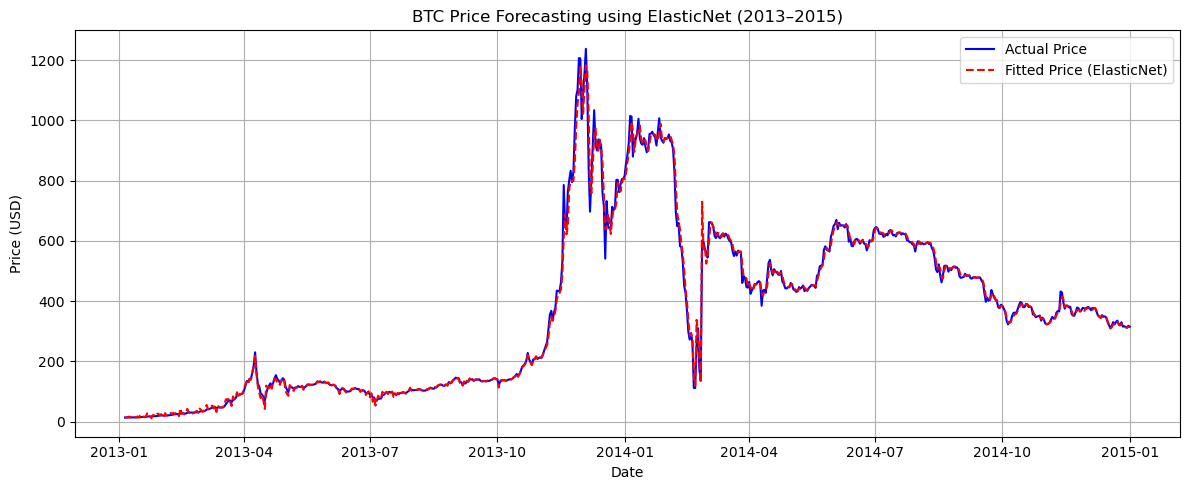


Out-of-sample performance:
R²: 0.9869164580860478
MAE: 5.336617353646704
RMSE: 7.914036874515142


c:\Users\giova\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.994e+04, tolerance: 5.364e+03
  model = cd_fast.enet_coordinate_descent(
c:\Users\giova\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


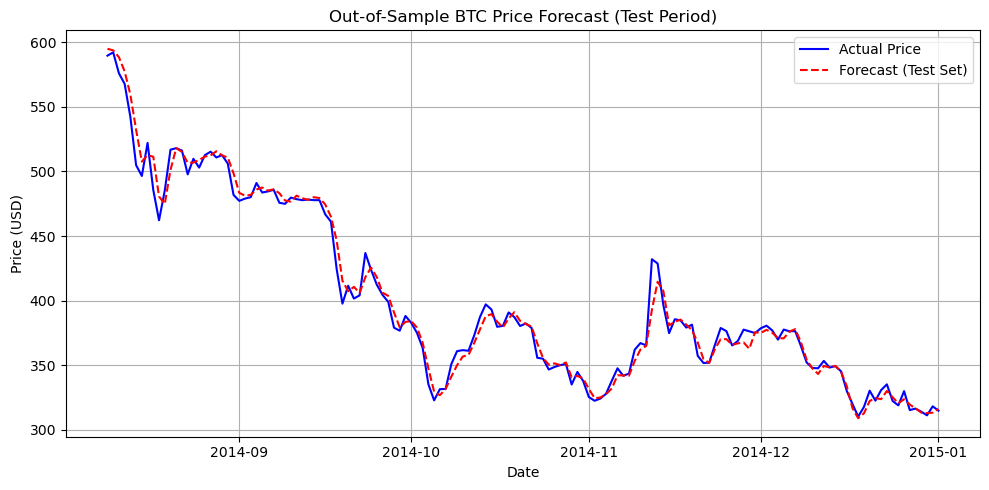

In [8]:
# --- Step 0: Imports ---
import requests
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

# --- Step 1: Download BTC Price Data (2013–2015) ---
def get_unix_timestamp(date_str):
    return int(datetime.strptime(date_str, "%Y-%m-%d").timestamp())

API_KEY = '404a6aea07fb8700da00a46a866d3813f7444289f56ce6902f6e8ca4e04be78c'
START_DATE = "2013-01-01"
END_DATE = "2015-01-01"
LIMIT_DAYS = 730

url = "https://min-api.cryptocompare.com/data/v2/histoday"
params = {
    'fsym': 'BTC',
    'tsym': 'USD',
    'limit': LIMIT_DAYS,
    'toTs': get_unix_timestamp(END_DATE),
    'api_key': API_KEY
}

response = requests.get(url, params=params)
data = response.json()
df = pd.DataFrame(data['Data']['Data'])
df['time'] = pd.to_datetime(df['time'], unit='s')

# Keep relevant columns
df['xt'] = df['volumeto']
df['yt'] = df['close']
df = df[['time', 'xt', 'yt']].dropna().reset_index(drop=True)

# --- Step 2: Feature Engineering (10+ features) ---
df['lag1'] = df['yt'].shift(1)
df['lag2'] = df['yt'].shift(2)
df['lag3'] = df['yt'].shift(3)
df['rolling_mean_5'] = df['yt'].rolling(5).mean()
df['rolling_std_5'] = df['yt'].rolling(5).std()
df['return'] = df['yt'].pct_change()
df['volume_change'] = df['xt'].pct_change()
df['day_of_week'] = df['time'].dt.dayofweek
df = pd.get_dummies(df, columns=['day_of_week'], drop_first=True)
df = df.dropna().reset_index(drop=True)

# --- Step 3: Prepare Data for Modeling ---
features = df.drop(columns=['time', 'yt'])
target = df['yt']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)
y = target.values

# --- Step 4: ElasticNetCV with TimeSeriesSplit ---
tscv = TimeSeriesSplit(n_splits=5)

model = ElasticNetCV(cv=tscv,
                     l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
                     random_state=42)
model.fit(X_scaled, y)

# --- Step 5: Output Results ---
print("Optimal alpha (regularisation strength):", model.alpha_)
print("Optimal L1 ratio (L1 vs L2 mix):", model.l1_ratio_)
print("R² Score on training data:", model.score(X_scaled, y))

# --- Step 6: Optional: Plot Actual vs Fitted ---
y_pred = model.predict(X_scaled)

plt.figure(figsize=(12, 5))
plt.plot(df['time'], y, label='Actual Price', color='blue')
plt.plot(df['time'], y_pred, label='Fitted Price (ElasticNet)', color='red', linestyle='--')
plt.title("BTC Price Forecasting using ElasticNet (2013–2015)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Step 7: Out-of-Sample Forecasting (Train/Test Split) ---
# Split data (80% train, 20% test)
split_idx = int(0.8 * len(X_scaled))
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
time_test = df['time'].iloc[split_idx:]

# Fit ElasticNet on training set
model = ElasticNetCV(cv=tscv, l1_ratio=[.1, .5, .9, 1], random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred_test = model.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print("\nOut-of-sample performance:")
print("R²:", r2_score(y_test, y_pred_test))
print("MAE:", mean_absolute_error(y_test, y_pred_test))
print("RMSE:", mean_squared_error(y_test, y_pred_test, squared=False))

# Plot out-of-sample forecast
plt.figure(figsize=(10, 5))
plt.plot(time_test, y_test, label='Actual Price', color='blue')
plt.plot(time_test, y_pred_test, label='Forecast (Test Set)', color='red', linestyle='--')
plt.title("Out-of-Sample BTC Price Forecast (Test Period)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("R²:", r2_score(y, y_pred))
print("MAE:", mean_absolute_error(y, y_pred))
print("RMSE:", mean_squared_error(y, y_pred, squared=False) ** 0.5)


R²: 0.9935809417016485
MAE: 10.0714947354657
RMSE: 4.685390338143128


c:\Users\giova\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Note on Stationarity: The raw Bitcoin price series is non-stationary, with patterns and volatility clustering. 

To solve this, we use initial differences (returns), rolling means, and Volatility characteristics.  To achieve full stationarity, additional transformation or ARIMA-style differencing could be used.


Top 10 Most Influential Features:
           Feature  Coefficient
1             lag1   195.111704
4   rolling_mean_5   138.278016
3             lag3   -48.893438
6           return    23.958078
2             lag2   -10.142074
0               xt    -4.560653
9    day_of_week_2    -0.536171
12   day_of_week_5    -0.423309
5    rolling_std_5     0.262153
11   day_of_week_4    -0.235468


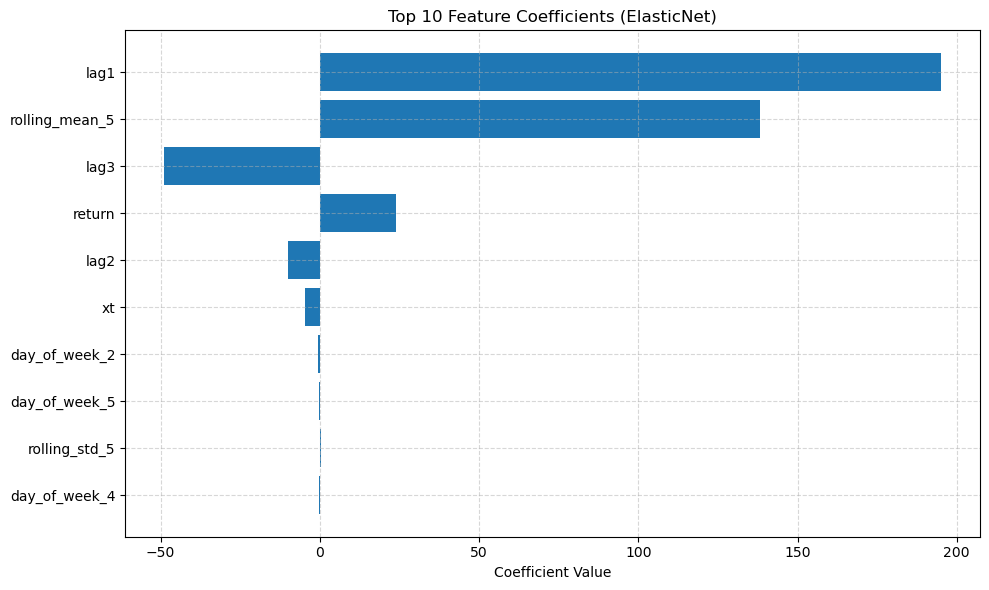

In [9]:
# --- Step 8: Feature Importance (ElasticNet Coefficients) ---
coef_df = pd.DataFrame({
    'Feature': features.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

print("\nTop 10 Most Influential Features:")
print(coef_df.head(10))

# Optional: Plot bar chart
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'].head(10)[::-1], coef_df['Coefficient'].head(10)[::-1])
plt.title("Top 10 Feature Coefficients (ElasticNet)")
plt.xlabel("Coefficient Value")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

